In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.auto import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [236]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)


In [262]:
CFG = {
    'TRAIN_WINDOW_SIZE':150, # 30일치로 학습
    'PREDICT_SIZE':40, # 10일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':42, 
    'SPLIT_RATE':0.8, 
    'MIN_DELTA':0.001 , 
    'PATIENCE':20 ,
    'NHEADS' : 2 , 
    'INDIVIDUAL': F
    
}

In [263]:
samsung =pd.read_csv('../data/삼성전자.csv')[['Date','Close','Volume']]
extrainfo= pd.read_csv('../data/extra_info.csv')
extrainfo = extrainfo.iloc[1:, :]
extrainfo = extrainfo[['날짜','개인','외국인','기관계','기타법인']].rename(columns={'날짜':'Date', '개인':'individ', '외국인':'foreign','기관계':'institute', '기타법인':'extras'})
extrainfo = extrainfo[ ::-1 ].reset_index(drop=True)
extrainfo['Date'] = pd.to_datetime(extrainfo['Date'],format='%y.%m.%d' )
samsung['Date']  =pd.to_datetime(samsung['Date'])

data  = samsung.merge(extrainfo, on='Date', how = 'left')
data[['individ', 'foreign', 'institute', 'extras']] =data[['individ', 'foreign', 'institute', 'extras']].astype(float)
data  = data[['Volume','individ','foreign','institute','extras','Close']]

## 주식 가격 탄력성 column 추가하기 


train = data.iloc[ :-(CFG['PREDICT_SIZE']), :]
vaild = data.iloc[-(CFG['PREDICT_SIZE']): , : ]
train = train.T 


In [264]:
# Only Class Definitions
from RevIN import RevIN
import torch
import torch.nn as nn

class momentum(nn.Module):
    def __init__(self, window_size):
        super(momentum, self).__init__()
        self.window_size = window_size

    def forward(self, x):
        # x: [Batch, Seq_len, Channels]
        momentum = x[:, self.window_size:, :] - x[:, :-self.window_size, :]
        padding = torch.zeros(x.size(0), self.window_size, x.size(2)).to(x.device)
        momentum = torch.cat([padding, momentum], dim=1)
        return momentum
    
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(nn.Module):
    def __init__(self, kernel_size, momentum_window):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)
        self.momentum = momentum(momentum_window)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        momentums =self.momentum(x) 
        return res, moving_mean , momentums
    
    
class ModelWithMultiheadAttention(nn.Module):
    def __init__(self, configs):
        super(ModelWithMultiheadAttention, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.d_model = configs.d_model
        self.n_heads = configs.n_heads
        self.channels = configs.enc_in
        self.kernel_size =configs.kernel_size
        self.momentum_window =configs.momentum_window
        self.individual = configs.individual
        # 선형 레이어를 사용하여 input_dim (채널 수)을 d_model (512)로 변환
        # self.linear_in = nn.Linear(self.channels, self.d_model)
        self.decomposition = series_decomp(self.kernel_size , self.momentum_window)
        # Multihead Attention 레이어
        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.seq_len, num_heads=self.n_heads, batch_first=True)

        if configs.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init, momentum_init = self.decomposition(x)
        # 계절성, 트렌드성 추출하기 
        seasonal_init, trend_init,momentum_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1) ,momentum_init.permute(0,2,1) 
        combined_features = trend_init + seasonal_init + momentum_init
        
        # Multihead Attention 적용(차원은 seq_len이랑 동일하게 설정하기 )
        attn_output, _ = self.multihead_attn(query=trend_init, key=momentum_init, value=seasonal_init)

        if self.individual:
            seasonal_output = torch.zeros([attn_output.size(0), self.channels, self.pred_len], dtype=attn_output.dtype).to(attn_output.device)
            trend_output = torch.zeros([attn_output.size(0), self.channels, self.pred_len], dtype=attn_output.dtype).to(attn_output.device)
            
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](attn_output[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(attn_output)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)  # [Batch, Output length, Channel]로 변환



class LTSF_DLinear(torch.nn.Module):
    def __init__(self, configs):
        super(LTSF_DLinear, self).__init__()
        self.window_size = configs.window_size
        self.forecast_size = configs.forecast_size
        self.decomposition = series_decomp(configs.kernel_size , 5)
        self.individual = configs.individual
        self.channels = configs.feature_size
        self.revin = RevIN(num_features=self.channels, eps=1e-5, affine=True, subtract_last=False)
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1 / self.window_size) * torch.ones([self.forecast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forecast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1 / self.window_size) * torch.ones([self.forecast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1 / self.window_size) * torch.ones([self.forecast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size, self.forecast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1 / self.window_size) * torch.ones([self.forecast_size, self.window_size]))

    def forward(self, x):
        # x = self.revin(x, mode='norm')
        trend_init, seasonal_init, moment  = self.decomposition(x)
        trend_init, seasonal_init = trend_init.permute(0, 2, 1), seasonal_init.permute(0, 2, 1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forecast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forecast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        # x = x.permute(0, 2, 1)
        # x = self.revin(x, mode='denorm')
        return x.permute(0, 2, 1)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [265]:
# Function to reshape the data into a time series format for each ID
def reshape_data(df):
    time_series_data = []
    for idx, row in df.iterrows():
        sales_data = row[0:].values.astype(float)
        time_series_data.append(sales_data)
    return np.array(time_series_data)

# Modified time_slide_df function to work with the current data format
def time_slide_df(data, window_size, forecast_size):
    data_list = []
    dap_list = []
    # len(data) = 1523 (데이터 전체에 몇 일치의 데이터인지 ), windowsize=72 (72일을 보고나서 28일을 예측하겠다), forecastsize = 28 
    # data_list = 1424x72  의 형태이다, dap_list =1424x 28 의 형태이다 즉, 하나의 제품에 대해서 1424개의 학습 데이터 셋이 만들어 진 것이다. 
    for idx in range(0, len(data) - window_size - forecast_size + 1):
        x = data[idx:idx + window_size].reshape(window_size, 1)
        
        y = data[idx + window_size:idx + window_size + forecast_size]
        data_list.append(x)
        dap_list.append(y)
    # print(f"{len(data_list)} is shape of x and {len(dap_list)} is shape of y , {len(data) }")
    # print(dap_list)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

# Function to create DataLoader for each ID
def create_dataloader(data, window_size, forecast_size, batch_size):
    X, Y = time_slide_df(data, window_size, forecast_size)
    ds = Data(X, Y)
    # print(ds())
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

time_series_data = reshape_data(train)

In [266]:
# 데이터 표준화
means = np.mean(time_series_data, axis=1, keepdims=True)
stds = np.std(time_series_data, axis=1, keepdims=True)
standardized_data = (time_series_data - means) / stds

# DataLoader 생성 함수 수정
from torch.utils.data import DataLoader, TensorDataset
def create_dataloader(data, train_window_size, predict_size, batch_size):
    sequences = []
    targets = []
    # data.shape[0] = channel cnt, data.shape[1] = total length
    for i in range(data.shape[1] - train_window_size - predict_size + 1):
        seq = data[:, i:i + train_window_size]
        target = data[:, i + train_window_size:i + train_window_size + predict_size]
        sequences.append(seq)
        targets.append(target)
    sequences = np.stack(sequences)
    targets = np.stack(targets)
    
    dataset = TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# DataLoader 생성
train_dl = create_dataloader(standardized_data, CFG['TRAIN_WINDOW_SIZE'], CFG['PREDICT_SIZE'], CFG['BATCH_SIZE'])

## Dlinear_withAttention

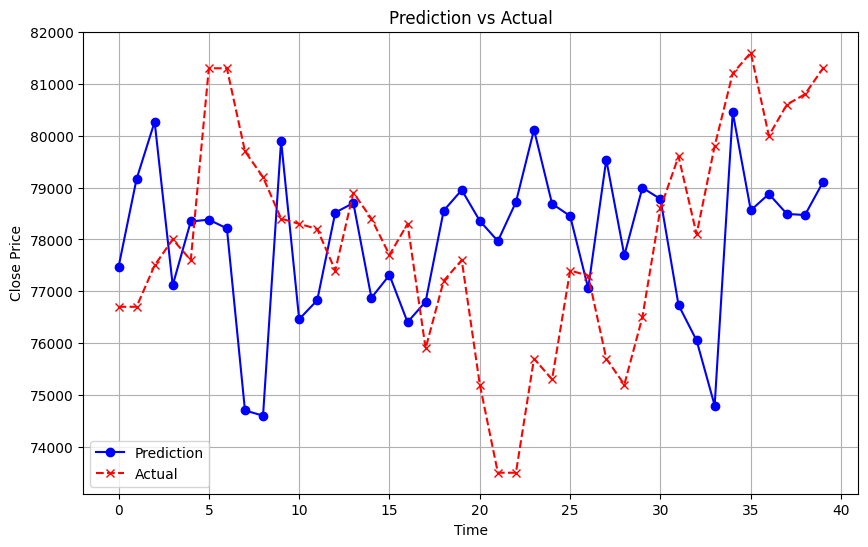

Root Mean Squared Error (RMSE): 2640.764061250297


In [112]:
import matplotlib.pyplot as plt
prediction_numpy = final_predict
for_score_close = vaild['Close']
for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
# 그래프 그리기
plt.figure(figsize=(10, 6)) 

plt.plot(final_predict[: , -1], marker='o', linestyle='-', color='b', label='Prediction')
# 실제 종가 데이터 그리기
plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')

# 그래프 제목, 축 이름, 범례 설정
plt.title('Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


res_df =for_score_close_last_10.values.tolist()
squared_differences = []
for i in range(40):
    difference = final_predict[:, -1][i] - res_df[i]
    squared_difference = difference ** 2
    squared_differences.append(squared_difference)
# 텐서를 numpy 배열로 변환하여 MSE 계산
squared_differences = torch.tensor(squared_differences)
mse = squared_differences.mean().detach().numpy()
# RMSE 계산
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# 시계열 데이터 반복
future_expect = []  # 예측 결과를 저장할 리스트
for seed in tqdm([42,109]) : 
    seed_everything(seed) 
        
    for idx, data in tqdm(enumerate(time_series_data), total=len(time_series_data)):
        # 데이터 표준화
        mean_ = np.mean(data)
        std_ = np.std(data)
        if std_ == 0:            standardized_data = data
        else:            standardized_data = (data - mean_) / std_
        # DataLoader 생성
        train_dl = create_dataloader(standardized_data, CFG['TRAIN_WINDOW_SIZE'], CFG['PREDICT_SIZE'], CFG['BATCH_SIZE'])
        
        # 모델 초기화 및 설정
        DLinear_model = LTSF_DLinear(window_size=CFG['TRAIN_WINDOW_SIZE'], forecast_size=CFG['PREDICT_SIZE'], kernel_size=21, individual=False, feature_size=1)
        DLinear_model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=CFG['LEARNING_RATE'])
        
        # 모델 훈련
        best_loss = float('inf')
        no_improvement_count = 0
        for epoch in range(1, CFG['EPOCHS'] + 1):
            loss_list = []
            DLinear_model.train()
            for batch_idx, (data, target) in enumerate(train_dl):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = DLinear_model(data)
                loss = criterion(output, target.unsqueeze(-1))
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
            
            # 에폭별 평균 손실 계산 및 출력
            avg_loss = np.mean(loss_list)
            print(f"Epoch {epoch}/CFG['EPOCHS'], 평균 손실: {avg_loss:.6f}")
            
            # 개선 여부 확인
            if avg_loss + CFG['MIN_DELTA'] < best_loss:
                best_loss = avg_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= CFG['PATIENCE']:
                    print(f"조기 종료: {epoch} 에폭에서 개선되지 않음")
                    break
        
        # 미래 예측
        last_window_data = torch.tensor(standardized_data[-CFG['TRAIN_WINDOW_SIZE']:]).unsqueeze(0).unsqueeze(-1).float().to(device)
        future_prediction = DLinear_model(last_window_data)
        
        # 원래 스케일로 변환
        if std_ == 0:
            future_prediction = future_prediction.squeeze().detach().cpu().numpy()
        else:
            future_prediction = future_prediction.squeeze().detach().cpu().numpy() * std_ + mean_
        
        # 결과 저장
        future_expect.append(future_prediction)
        
# 각 시드별 예측 결과의 평균을 구하여 최종 결과로 저장
final_predict = np.mean(future_expect, axis=0)

# 모델별 RMSE 비교표

| Window Size | LSTM   | Nlinear | Dlinear | SegRNN |
|-------------|--------|---------|---------|--------|
| 40          | 2520   | -       | -       | -      |
| 60          | 2951   | 2700    | 2272    | 2045   |
| 90          | 2194   | 2951    | 2405    | 2090   |
| 120         | 2419   | 2598    | 2352    | 2183   |
| 150         | 3320   | 2625    | 2341    | 2100   |
| 180         | 2257   | 2691    | 2450    | 2129   |
| 240         | -      | -       | -       | 2136   |



In [243]:
def eval_DliAttention(n_heads,individual, kernel_size,momentum_size):
    class Configs:
        def __init__(self):
            self.seq_len = CFG['TRAIN_WINDOW_SIZE']          # 입력 시계열 데이터의 길이 (시간 스텝 수)
            self.pred_len = CFG['PREDICT_SIZE']         # 예측할 시계열 데이터의 길이
            self.d_model = 128         # 모델 차원 (임베딩 차원)
            self.n_heads = n_heads         # Multihead Attention의 헤드 수
            self.individual = individual    # 각 채널별로 개별 Linear 레이어를 사용할지 여부
            self.enc_in = 6            # 입력 채널 수 (예시 데이터에서 `indiv`, `fori`, `company` 등 포함)
            self.kernel_size=kernel_size
            self.momentum_window = momentum_size 
    # Configs 인스턴스 생성
    configs = Configs()
    future_expect =[]
    for seed in [42,109]:
        seed_everything(seed)
        DLinear_model = ModelWithMultiheadAttention(configs=configs)
        DLinear_model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=CFG['LEARNING_RATE'])
        best_loss = float('inf')
        no_improvement_count = 0
        #train 
        for epoch in range(1,100+1):
            loss_list =[]
            DLinear_model.train()
            for batch_idx,(data,target) in enumerate(train_dl):
                data,target=data.to(device),target.to(device)
                target_last_channel = target[:, -1, :]  # Shape: (256, 6,40)
                optimizer.zero_grad()
                data= data.permute(0,2,1)
                target=target.permute(0,2,1)
                output = DLinear_model(data) # (256, 40,6)
                output_last_channel = output[:,:, -1]  # Shape: (256, 40)

                loss = criterion(output_last_channel,target_last_channel) 
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
                
            avg_loss = np.mean(loss_list)
            # print(f"Epoch {epoch}/{CFG['EPOCHS']}, 평균 손실: {avg_loss:.6f}")
            # 개선 여부 확인
            if avg_loss + CFG['MIN_DELTA'] < best_loss:
                best_loss = avg_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= CFG['PATIENCE']:
                    print(f"조기 종료: {epoch} 에폭에서 개선되지 않음")
                    break
        # real predict 
        last_window_data = torch.tensor(standardized_data[:, -CFG['TRAIN_WINDOW_SIZE']:]).unsqueeze(0).float().to(device)
        last_window_data = last_window_data.permute(0,2,1)
        future_prediction = DLinear_model(last_window_data)
        
        future_prediction = future_prediction.squeeze(0).detach().cpu().numpy()  # shape: (20, 6)

        # 각 컬럼별로 표준편차와 평균을 곱하고 더하여 원래 스케일로 변환
        for i in range(future_prediction.shape[1]):  # 각 컬럼에 대해
            future_prediction[:, i] = future_prediction[:, i] * stds[i] + means[i]
            
        # 결과 저장
        future_expect.append(future_prediction)
            
    # 각 시드별 예측 결과의 평균을 구하여 최종 결과로 저장
    final_predict = np.mean(future_expect, axis=0)
    final_predict = final_predict.T
    expect_vals = final_predict[5]
    
    # print(dmodel,n_heads,drop,layer,diff)
    prediction_numpy = expect_vals
    for_score_close = vaild['Close']
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    plt.figure(figsize=(9, 4))  # 그래프의 크기 설정
    plt.plot(prediction_numpy, marker='o', linestyle='-', color='b', label='Prediction')
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    plt.title('Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    res_df =for_score_close_last_10.values.tolist()
    squared_differences = []
    for i in range(40):
        difference = expect_vals[i] - res_df[i]
        squared_difference = difference ** 2
        squared_differences.append(squared_difference)
    # 텐서를 numpy 배열로 변환하여 MSE 계산
    squared_differences = torch.tensor(squared_differences)
    mse = squared_differences.mean().detach().numpy()
    # RMSE 계산
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("*************************************************************************************")
    return prediction_numpy
    

In [208]:
def eval_Dlinear(kernel_size,individual):
    class Configs:
        def __init__(self):
            self.window_size = CFG['TRAIN_WINDOW_SIZE']          # 입력 시계열 데이터의 길이 (시간 스텝 수)
            self.forecast_size = CFG['PREDICT_SIZE']         # 예측할 시계열 데이터의 길이
            self.channels = 6            # 입력 채널 수 (예시 데이터에서 `indiv`, `fori`, `company` 등 포함)
            self.kernel_size=kernel_size
            self.individual = individual
            self.feature_size =6 
    # Configs 인스턴스 생성
    configs = Configs()
    future_expect=[]
    for seed in [42,109]:
        seed_everything(seed)
        DLinear_model = LTSF_DLinear(configs=configs)
        DLinear_model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=CFG['LEARNING_RATE'])
        best_loss = float('inf')
        no_improvement_count = 0
        #train 
        for epoch in range(1,100+1):
            loss_list =[]
            DLinear_model.train()
            for batch_idx,(data,target) in enumerate(train_dl):
                data,target=data.to(device),target.to(device)
                target_last_channel = target[:, -1, :]  # Shape: (256, 6,40)
                optimizer.zero_grad()
                data= data.permute(0,2,1)
                target=target.permute(0,2,1)
                output = DLinear_model(data) # (256, 40,6)
                output_last_channel = output[:,:, -1]  # Shape: (256, 40)

                loss = criterion(output_last_channel,target_last_channel) 
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
                
            avg_loss = np.mean(loss_list)
            # 개선 여부 확인
            if avg_loss + CFG['MIN_DELTA'] < best_loss:
                best_loss = avg_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if no_improvement_count >= CFG['PATIENCE']:
                    print(f"조기 종료: {epoch} 에폭에서 개선되지 않음")
                    break
        # real predict 
        last_window_data = torch.tensor(standardized_data[:, -CFG['TRAIN_WINDOW_SIZE']:]).unsqueeze(0).float().to(device)
        last_window_data = last_window_data.permute(0,2,1)
        future_prediction = DLinear_model(last_window_data)
        
        future_prediction = future_prediction.squeeze(0).detach().cpu().numpy()  # shape: (20, 6)

        # 각 컬럼별로 표준편차와 평균을 곱하고 더하여 원래 스케일로 변환
        for i in range(future_prediction.shape[1]):  # 각 컬럼에 대해
            future_prediction[:, i] = future_prediction[:, i] * stds[i] + means[i]
            
        # 결과 저장
        future_expect.append(future_prediction)
        
            
    # 각 시드별 예측 결과의 평균을 구하여 최종 결과로 저장
    final_predict = np.mean(future_expect, axis=0)
    final_predict = final_predict.T
    expect_vals = final_predict[5]
    
    # print(dmodel,n_heads,drop,layer,diff)
    prediction_numpy = expect_vals
    for_score_close = vaild['Close']
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    plt.figure(figsize=(9, 4))  # 그래프의 크기 설정
    plt.plot(prediction_numpy, marker='o', linestyle='-', color='b', label='Prediction')
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    plt.title('Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    res_df =for_score_close_last_10.values.tolist()
    squared_differences = []
    for i in range(40):
        difference = expect_vals[i] - res_df[i]
        squared_difference = difference ** 2
        squared_differences.append(squared_difference)
    # 텐서를 numpy 배열로 변환하여 MSE 계산
    squared_differences = torch.tensor(squared_differences)
    mse = squared_differences.mean().detach().numpy()
    # RMSE 계산
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print("*************************************************************************************")
    return prediction_numpy
    
    

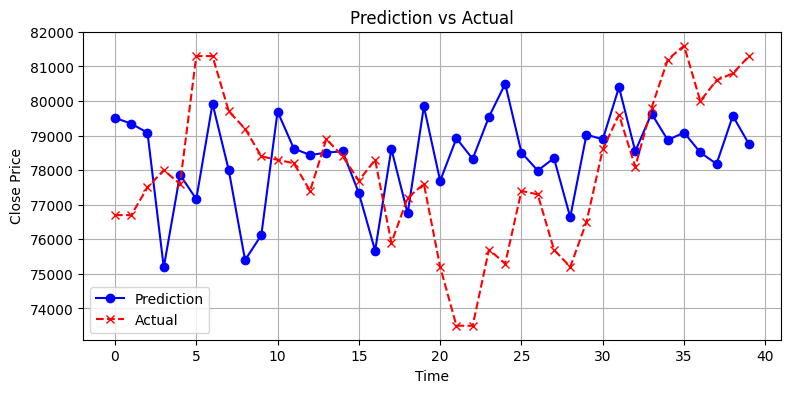

Root Mean Squared Error (RMSE): 2431.748868216119
*************************************************************************************


In [267]:
# pred60 = eval_DliAttention(1,True, 21,4)
# pred90 =eval_DliAttention(1,False, 15,4)
# pred120=eval_DliAttention(1,False, 15,4)
pred150= eval_DliAttention(1,False, 21,4)

1 False 15 4


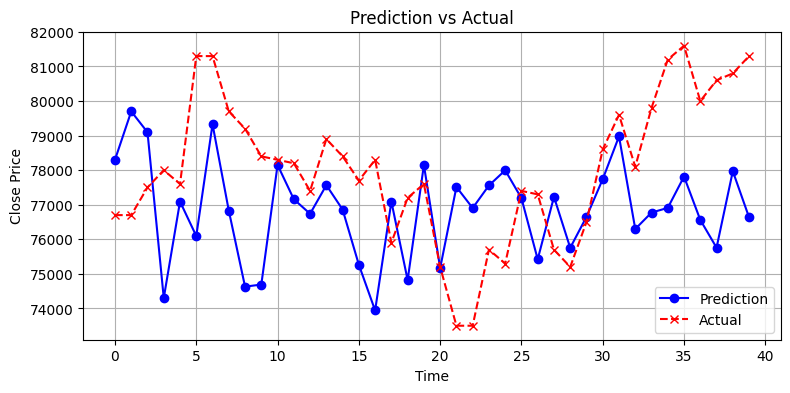

Root Mean Squared Error (RMSE): 2719.8985981647747
*************************************************************************************
1 False 15 5


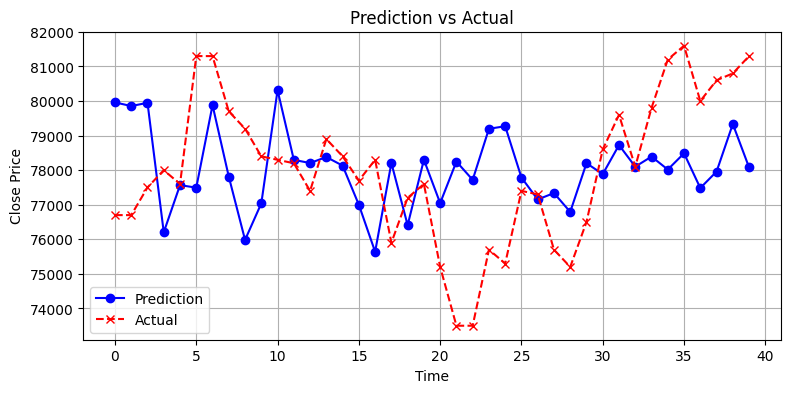

Root Mean Squared Error (RMSE): 2291.7909604441666
*************************************************************************************
1 False 21 4


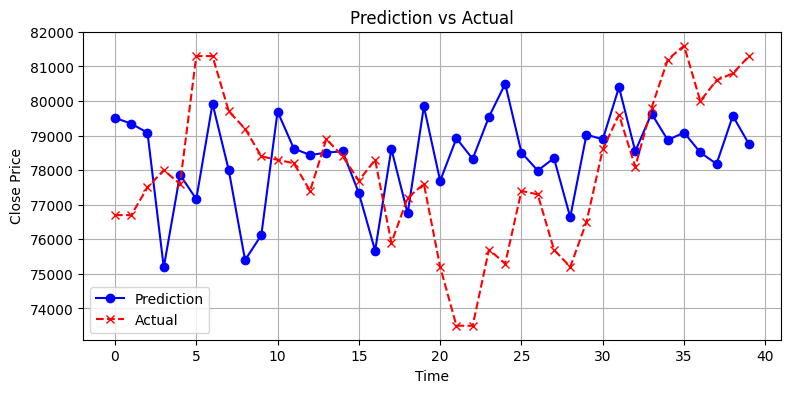

Root Mean Squared Error (RMSE): 2431.748868216119
*************************************************************************************
1 False 21 5


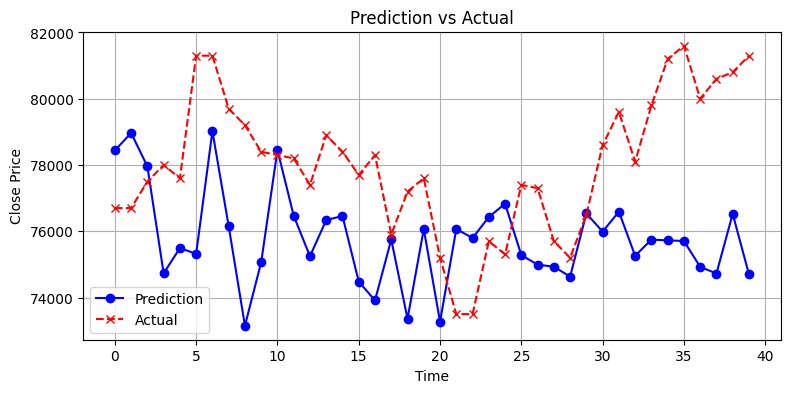

Root Mean Squared Error (RMSE): 3338.5211935767215
*************************************************************************************
1 True 15 4


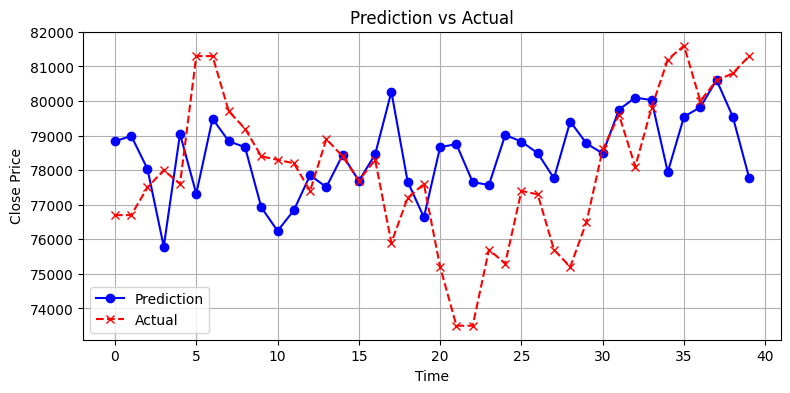

Root Mean Squared Error (RMSE): 2266.7896609683617
*************************************************************************************
1 True 15 5


KeyboardInterrupt: 

In [242]:
# Dlinear_withAttention 1 True 21 4 (2391) ,60 
# 1 False 15 4               ,90 winsize (2220)
# 1 False 15 4 , 120 , 2142 
# 1 False 21 4  ,150 2431
for n_heads in [1,2,3,6]:
    for individual in [False, True]:
        for kernel_size in [15,21]:
            for mom_size in [4,5]:
                print(n_heads, individual, kernel_size,mom_size)
                eval_DliAttention(n_heads,individual, kernel_size,mom_size)
                    

## 모델마다 제일 좋은 하이퍼파라미터 찾기 -> windowsize 변화하면서 보기, 
##                                     -> 가격탄력성 추가해서 보기 

# dlinear 15 False ()

In [210]:
# 2711 60 
# 2728.436087901277 90 
# 2576 120 
#2669 150 


array([79857.516, 79854.08 , 79675.92 , 79463.75 , 79329.34 , 79127.25 ,
       78903.555, 78939.984, 78908.42 , 78911.85 , 78877.766, 78869.56 ,
       78875.42 , 79000.875, 79118.15 , 79182.734, 79380.02 , 79483.555,
       79615.125, 79644.24 , 79611.65 , 79702.64 , 79735.22 , 79682.16 ,
       79776.   , 79712.914, 79785.625, 79899.48 , 79921.69 , 80071.625,
       80103.164, 80046.09 , 79926.71 , 79843.89 , 79812.484, 79723.234,
       79589.33 , 79527.336, 79569.53 , 79541.94 ], dtype=float32)

조기 종료: 94 에폭에서 개선되지 않음
조기 종료: 97 에폭에서 개선되지 않음


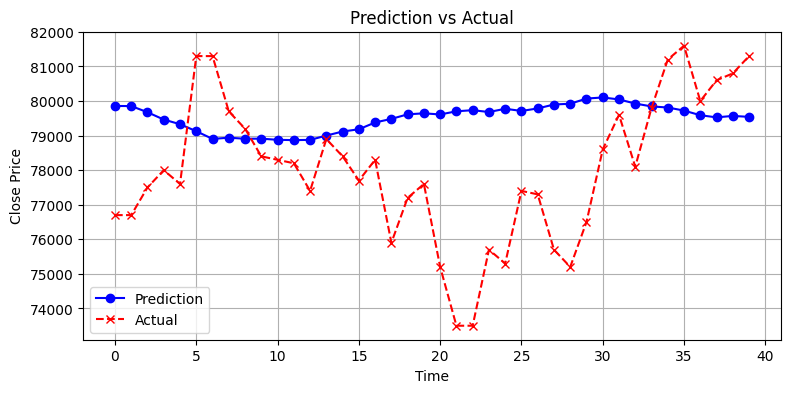

Root Mean Squared Error (RMSE): 2669.112827856775
*************************************************************************************


In [209]:
# predict_60 = eval_Dlinear(15, False)
predict_150 = eval_Dlinear(15, False)

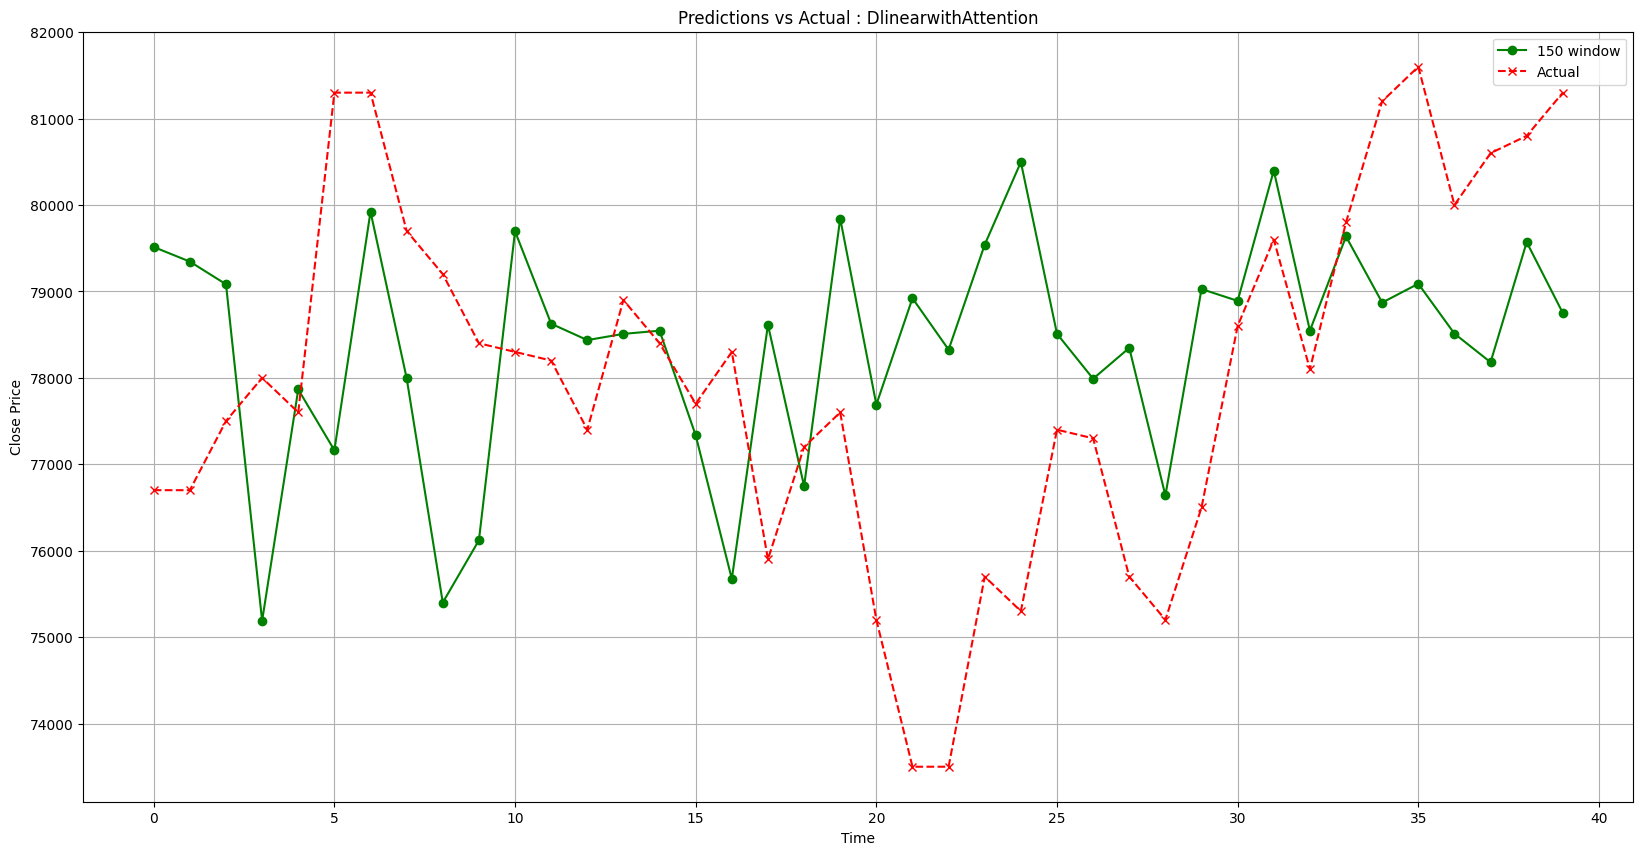

In [280]:

def plot_predictions(window_60, window_90, window_120, window_150, for_score_close, CFG):
    # 실제 값 추출
    for_score_close_last_10 = for_score_close[-CFG['PREDICT_SIZE']:]
    
    # 시각화
    plt.figure(figsize=(20, 10))  # 그래프의 크기 설정
    
    # 각 예측 값 시각화
    # plt.plot(window_60, marker='o', linestyle='-', color='b', label='60 window')
    # plt.plot(window_90, marker='o', linestyle='-', color='g', label='90 window')
    # plt.plot(window_120, marker='o', linestyle='-', color='b', label='120 window')
    plt.plot(window_150, marker='o', linestyle='-', color='g', label='150 window')
    
    # 실제 값 시각화
    plt.plot(for_score_close_last_10.values, marker='x', linestyle='--', color='r', label='Actual')
    
    # 그래프의 제목 및 축 레이블 설정
    plt.title('Predictions vs Actual : DlinearwithAttention')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# 함수 호출 예시
plot_predictions(pred60, pred90, pred120, pred150, vaild['Close'], CFG)


15 False
Epoch 1/100, 평균 손실: 0.039482
Epoch 2/100, 평균 손실: 0.037799
Epoch 3/100, 평균 손실: 0.036485
Epoch 4/100, 평균 손실: 0.035782
Epoch 5/100, 평균 손실: 0.034288
Epoch 6/100, 평균 손실: 0.033749
Epoch 7/100, 평균 손실: 0.033622
Epoch 8/100, 평균 손실: 0.032154
Epoch 9/100, 평균 손실: 0.031971
Epoch 10/100, 평균 손실: 0.030524
Epoch 11/100, 평균 손실: 0.030630
Epoch 12/100, 평균 손실: 0.029390
Epoch 13/100, 평균 손실: 0.029185
Epoch 14/100, 평균 손실: 0.028110
Epoch 15/100, 평균 손실: 0.028164
Epoch 16/100, 평균 손실: 0.027357
Epoch 17/100, 평균 손실: 0.026971
Epoch 18/100, 평균 손실: 0.026485
Epoch 19/100, 평균 손실: 0.026534
Epoch 20/100, 평균 손실: 0.025219
Epoch 21/100, 평균 손실: 0.025001
Epoch 22/100, 평균 손실: 0.024442
Epoch 23/100, 평균 손실: 0.024618
Epoch 24/100, 평균 손실: 0.023790
Epoch 25/100, 평균 손실: 0.024003
Epoch 26/100, 평균 손실: 0.023274
Epoch 27/100, 평균 손실: 0.023220
Epoch 28/100, 평균 손실: 0.023094
Epoch 29/100, 평균 손실: 0.022446
Epoch 30/100, 평균 손실: 0.022524
Epoch 31/100, 평균 손실: 0.022168
Epoch 32/100, 평균 손실: 0.022407
Epoch 33/100, 평균 손실: 0.021568
Epoch 34/1

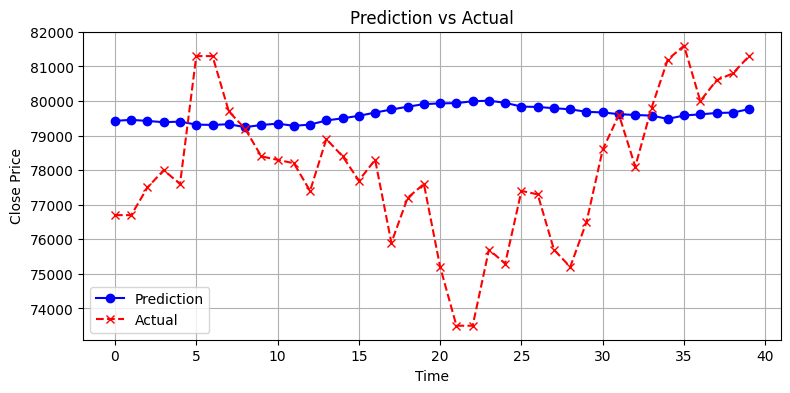

Root Mean Squared Error (RMSE): 2711.7253921834167
*************************************************************************************
15 True
Epoch 1/100, 평균 손실: 0.042007
Epoch 2/100, 평균 손실: 0.039847
Epoch 3/100, 평균 손실: 0.038733
Epoch 4/100, 평균 손실: 0.037634
Epoch 5/100, 평균 손실: 0.036550
Epoch 6/100, 평균 손실: 0.036349
Epoch 7/100, 평균 손실: 0.034952
Epoch 8/100, 평균 손실: 0.034294
Epoch 9/100, 평균 손실: 0.034235
Epoch 10/100, 평균 손실: 0.032724
Epoch 11/100, 평균 손실: 0.031803
Epoch 12/100, 평균 손실: 0.031344
Epoch 13/100, 평균 손실: 0.030454
Epoch 14/100, 평균 손실: 0.029957
Epoch 15/100, 평균 손실: 0.029506
Epoch 16/100, 평균 손실: 0.028958
Epoch 17/100, 평균 손실: 0.028515
Epoch 18/100, 평균 손실: 0.027669
Epoch 19/100, 평균 손실: 0.027590
Epoch 20/100, 평균 손실: 0.026737
Epoch 21/100, 평균 손실: 0.026208
Epoch 22/100, 평균 손실: 0.025739
Epoch 23/100, 평균 손실: 0.026234
Epoch 24/100, 평균 손실: 0.025134
Epoch 25/100, 평균 손실: 0.024810
Epoch 26/100, 평균 손실: 0.024944
Epoch 27/100, 평균 손실: 0.024087
Epoch 28/100, 평균 손실: 0.023961
Epoch 29/100, 평균 손실: 0.0

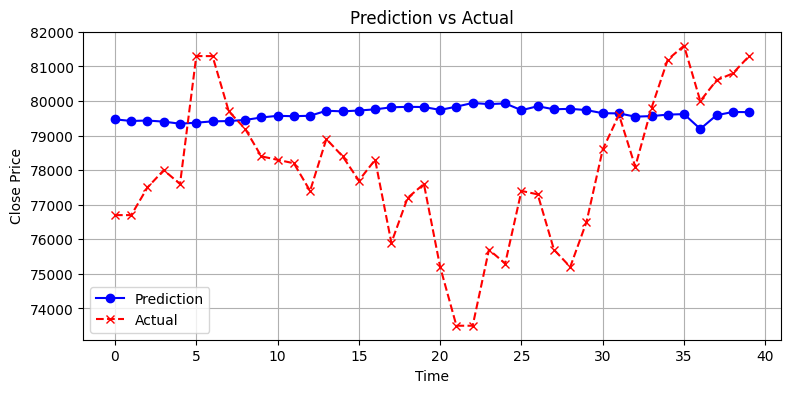

Root Mean Squared Error (RMSE): 2707.320788876308
*************************************************************************************
21 False
Epoch 1/100, 평균 손실: 0.039480
Epoch 2/100, 평균 손실: 0.037792
Epoch 3/100, 평균 손실: 0.036471
Epoch 4/100, 평균 손실: 0.035763
Epoch 5/100, 평균 손실: 0.034260
Epoch 6/100, 평균 손실: 0.033715
Epoch 7/100, 평균 손실: 0.033576
Epoch 8/100, 평균 손실: 0.032104
Epoch 9/100, 평균 손실: 0.031910
Epoch 10/100, 평균 손실: 0.030454
Epoch 11/100, 평균 손실: 0.030553
Epoch 12/100, 평균 손실: 0.029296
Epoch 13/100, 평균 손실: 0.029094
Epoch 14/100, 평균 손실: 0.028010
Epoch 15/100, 평균 손실: 0.028051
Epoch 16/100, 평균 손실: 0.027231
Epoch 17/100, 평균 손실: 0.026833
Epoch 18/100, 평균 손실: 0.026336
Epoch 19/100, 평균 손실: 0.026383
Epoch 20/100, 평균 손실: 0.025058
Epoch 21/100, 평균 손실: 0.024824
Epoch 22/100, 평균 손실: 0.024264
Epoch 23/100, 평균 손실: 0.024419
Epoch 24/100, 평균 손실: 0.023584
Epoch 25/100, 평균 손실: 0.023782
Epoch 26/100, 평균 손실: 0.023050
Epoch 27/100, 평균 손실: 0.022977
Epoch 28/100, 평균 손실: 0.022855
Epoch 29/100, 평균 손실: 0.0

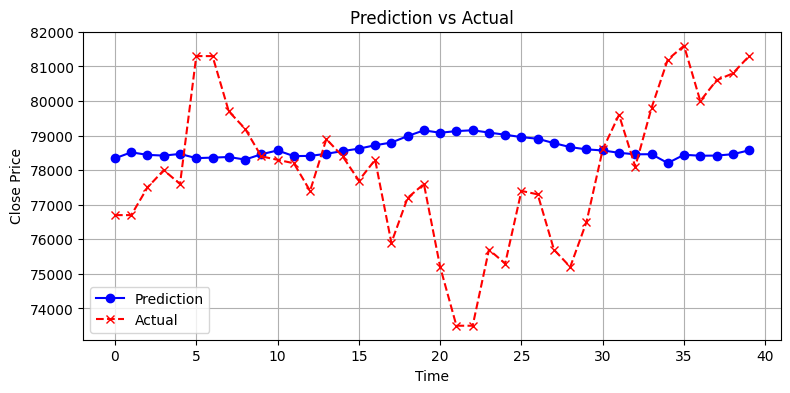

Root Mean Squared Error (RMSE): 2352.119236497335
*************************************************************************************
21 True
Epoch 1/100, 평균 손실: 0.042004
Epoch 2/100, 평균 손실: 0.039838
Epoch 3/100, 평균 손실: 0.038717
Epoch 4/100, 평균 손실: 0.037609
Epoch 5/100, 평균 손실: 0.036519
Epoch 6/100, 평균 손실: 0.036310
Epoch 7/100, 평균 손실: 0.034907
Epoch 8/100, 평균 손실: 0.034236
Epoch 9/100, 평균 손실: 0.034169
Epoch 10/100, 평균 손실: 0.032650
Epoch 11/100, 평균 손실: 0.031716
Epoch 12/100, 평균 손실: 0.031245
Epoch 13/100, 평균 손실: 0.030345
Epoch 14/100, 평균 손실: 0.029839
Epoch 15/100, 평균 손실: 0.029380
Epoch 16/100, 평균 손실: 0.028818
Epoch 17/100, 평균 손실: 0.028371
Epoch 18/100, 평균 손실: 0.027519
Epoch 19/100, 평균 손실: 0.027417
Epoch 20/100, 평균 손실: 0.026550
Epoch 21/100, 평균 손실: 0.026032
Epoch 22/100, 평균 손실: 0.025548
Epoch 23/100, 평균 손실: 0.026016
Epoch 24/100, 평균 손실: 0.024917
Epoch 25/100, 평균 손실: 0.024586
Epoch 26/100, 평균 손실: 0.024716
Epoch 27/100, 평균 손실: 0.023849
Epoch 28/100, 평균 손실: 0.023697
Epoch 29/100, 평균 손실: 0.02

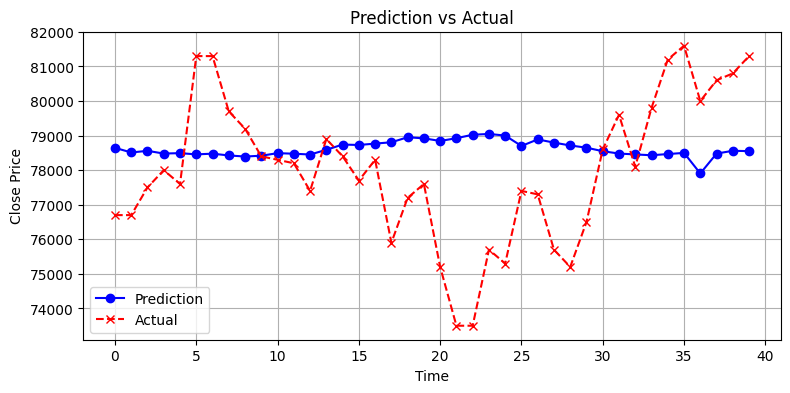

Root Mean Squared Error (RMSE): 2314.3282013886183
*************************************************************************************
25 False
Epoch 1/100, 평균 손실: 0.039477
Epoch 2/100, 평균 손실: 0.037784
Epoch 3/100, 평균 손실: 0.036456
Epoch 4/100, 평균 손실: 0.035743
Epoch 5/100, 평균 손실: 0.034231
Epoch 6/100, 평균 손실: 0.033681
Epoch 7/100, 평균 손실: 0.033532
Epoch 8/100, 평균 손실: 0.032055
Epoch 9/100, 평균 손실: 0.031852
Epoch 10/100, 평균 손실: 0.030390
Epoch 11/100, 평균 손실: 0.030482
Epoch 12/100, 평균 손실: 0.029213
Epoch 13/100, 평균 손실: 0.029011
Epoch 14/100, 평균 손실: 0.027919
Epoch 15/100, 평균 손실: 0.027950
Epoch 16/100, 평균 손실: 0.027123
Epoch 17/100, 평균 손실: 0.026719
Epoch 18/100, 평균 손실: 0.026215
Epoch 19/100, 평균 손실: 0.026254
Epoch 20/100, 평균 손실: 0.024924
Epoch 21/100, 평균 손실: 0.024681
Epoch 22/100, 평균 손실: 0.024119
Epoch 23/100, 평균 손실: 0.024260
Epoch 24/100, 평균 손실: 0.023422
Epoch 25/100, 평균 손실: 0.023611
Epoch 26/100, 평균 손실: 0.022874
Epoch 27/100, 평균 손실: 0.022789
Epoch 28/100, 평균 손실: 0.022666
Epoch 29/100, 평균 손실: 0.

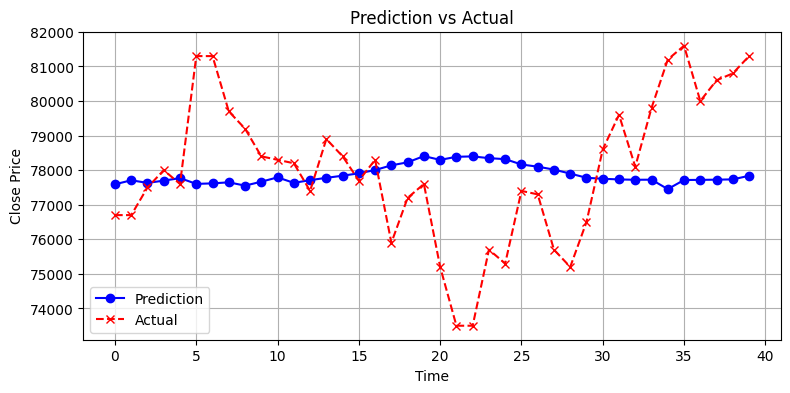

Root Mean Squared Error (RMSE): 2277.652701820823
*************************************************************************************
25 True
Epoch 1/100, 평균 손실: 0.042000
Epoch 2/100, 평균 손실: 0.039829
Epoch 3/100, 평균 손실: 0.038701
Epoch 4/100, 평균 손실: 0.037585
Epoch 5/100, 평균 손실: 0.036488
Epoch 6/100, 평균 손실: 0.036271
Epoch 7/100, 평균 손실: 0.034863
Epoch 8/100, 평균 손실: 0.034181
Epoch 9/100, 평균 손실: 0.034107
Epoch 10/100, 평균 손실: 0.032585
Epoch 11/100, 평균 손실: 0.031640
Epoch 12/100, 평균 손실: 0.031157
Epoch 13/100, 평균 손실: 0.030252
Epoch 14/100, 평균 손실: 0.029736
Epoch 15/100, 평균 손실: 0.029273
Epoch 16/100, 평균 손실: 0.028703
Epoch 17/100, 평균 손실: 0.028251
Epoch 18/100, 평균 손실: 0.027394
Epoch 19/100, 평균 손실: 0.027281
Epoch 20/100, 평균 손실: 0.026402
Epoch 21/100, 평균 손실: 0.025891
Epoch 22/100, 평균 손실: 0.025396
Epoch 23/100, 평균 손실: 0.025842
Epoch 24/100, 평균 손실: 0.024747
Epoch 25/100, 평균 손실: 0.024414
Epoch 26/100, 평균 손실: 0.024537
Epoch 27/100, 평균 손실: 0.023664
Epoch 28/100, 평균 손실: 0.023497
Epoch 29/100, 평균 손실: 0.02

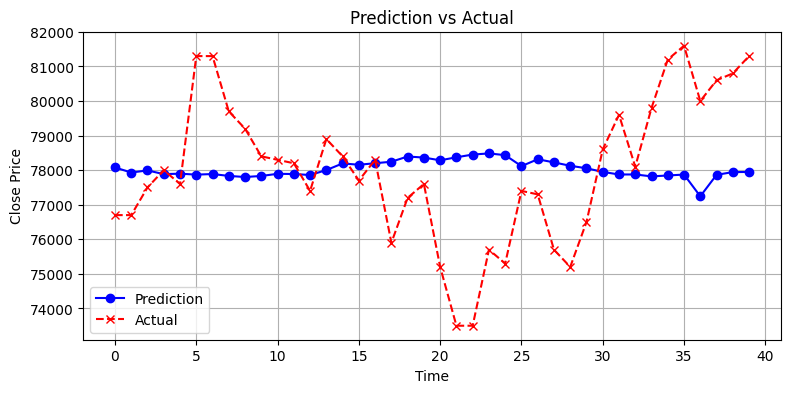

Root Mean Squared Error (RMSE): 2253.897508563936
*************************************************************************************


In [156]:
for ksize in [15,21,25] :
    for indiv in [False, True] :
        print(ksize, indiv) 
        eval_Dlinear(ksize, indiv)